In [1]:
import numpy as np
import cobaya
import cosmopower
import classy_sz
import scipy
import yaml


from getdist import loadMCSamples, MCSamples
from getdist import plots

from cosmopower import cosmopower_NN
from cosmopower import cosmopower_PCAplusNN


import soliket
import cobaya


#
import matplotlib
import matplotlib.pyplot as plt

import pprint 

import subprocess

%matplotlib inline
classy_sz.__file__

2023-04-10 18:13:13.919390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-04-10 18:13:21.417849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/Users/karenperezsarmiento/Desktop/lensing_proj/class_sz/python/classy_sz.cpython-310-darwin.so'

# Loading the input yaml file 

First, let's load the input yaml file

In [2]:
import os
root_path = os.path.abspath("")
prev_path = os.path.abspath("..")
print(root_path)
print(prev_path)

/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks
/Users/karenperezsarmiento/Desktop/lensing_proj


In [4]:
DR6_lensing_only_yaml = yaml.safe_load(open(root_path+'/lcdm_actplanck_baseline_167926925701.classy_szfast_mcmc.yaml'))

We will have to change the paths to the likelihoods and the outputs in the setup file. The likelihoods needed are the ACTDR6LensLike (accessible here) and the BAO likelihoods (can be downloaded using Cobaya). 

In [5]:
path_to_bao_lkl = prev_path+"/cosmo_pkgs/data"
DR6_lensing_only_yaml["likelihood"]['bao.sdss_dr12_lrg_bao_dmdh']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml["likelihood"]['bao.sdss_dr16_lrg_bao_dmdh']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml["likelihood"]['bao.sdss_dr7_mgs']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml["likelihood"]['bao.sixdf_2011_bao']['path'] = path_to_bao_lkl

Checking the changes were implemented:

In [6]:
pp = pprint.PrettyPrinter(indent=3)
pp.pprint(DR6_lensing_only_yaml["likelihood"])

{  'act_dr6_lenslike.ACTDR6LensLike': {  'apply_hartlap': True,
                                         'input_params': [],
                                         'kmax': 10,
                                         'lens_only': True,
                                         'limber': False,
                                         'lmax': 4000,
                                         'mock': False,
                                         'no_like_corrections': True,
                                         'nsims_act': 792.0,
                                         'nsims_planck': 400.0,
                                         'nz': 100,
                                         'output_params': [],
                                         'scale_cov': None,
                                         'speed': -1,
                                         'stop_at_error': True,
                                         'trim_lmax': 2998,
                                         'type

Let's take a look at the parameters section of the input yaml file. Nothing has to be changed here.

In [7]:
pp.pprint(DR6_lensing_only_yaml["params"])

{  'A': {'derived': 'lambda As: 1e9*As', 'latex': '10^9 A_\\mathrm{s}'},
   'As': {'derived': True, 'latex': 'A_\\mathrm{s}'},
   'H0': {  'latex': 'H_0',
            'prior': {'max': 90.0, 'min': 50.0},
            'proposal': 2.0,
            'ref': {'dist': 'norm', 'loc': 69.351243, 'scale': 2.0}},
   'S825': {  'derived': 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.25',
              'latex': '\\sigma_8 (\\Omega_\\mathrm{m}/0.3)^{0.25}'},
   'S85': {  'derived': 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.5',
             'latex': '\\sigma_8 (\\Omega_\\mathrm{m}/0.3)^{0.5}'},
   'YHe': {'derived': True, 'latex': 'Y_\\mathrm{P}'},
   'age': {'derived': True, 'latex': '{\\rm{Age}}/\\mathrm{Gyr}'},
   'chi2__BAO': {'derived': True, 'latex': '\\chi^2_\\mathrm{BAO}'},
   'logA': {  'latex': 'ln10^{10}A_s',
              'prior': {'max': 3.5, 'min': 2.5},
              'proposal': 0.12892144,
              'ref': {'dist': 'norm', 'loc': 2.9939341, 'scale': 0.12892144}},
   'n_s': {

Notice how we are using classy_szfast as the theory code!

In [8]:
pp.pprint(DR6_lensing_only_yaml["theory"])

{  'classy_szfast.classy_sz.classy_sz': {  'ell_factor': False,
                                           'extra_args': {  'N_ncdm': 1,
                                                            'N_ur': 2.0328,
                                                            'k_pivot': 0.05,
                                                            'modes': 's,t',
                                                            'output': 'tCl,lCl,pCl',
                                                            'skip_background_and_thermo': 0,
                                                            'skip_pkl': 1,
                                                            'skip_pknl': 1},
                                           'lensing_lkl': 'ACT',
                                           'path': None,
                                           'speed': 0.2,
                                           'stop_at_error': True,
                                           'use_class_sz_fa

As usual, MCMC will be the sampler

In [9]:
pp.pprint(DR6_lensing_only_yaml["sampler"])

{  'evaluate': {  'override': {  'H0': 67.2704,
                                 'logA': 3.05321,
                                 'n_s': 0.961653,
                                 'omega_b': 0.0209522,
                                 'omega_cdm': 0.115468}},
   'mcmc': {  'Rminus1_cl_level': 0.95,
              'Rminus1_cl_stop': 0.2,
              'Rminus1_single_split': 4,
              'Rminus1_stop': 0.01,
              'burn_in': 0,
              'callback_every': None,
              'callback_function': None,
              'check_every': None,
              'covmat': 'auto',
              'covmat_params': None,
              'drag': False,
              'drag_limits': None,
              'fallback_covmat_scale': 4,
              'learn_every': '40d',
              'learn_proposal': True,
              'learn_proposal_Rminus1_max': 2.0,
              'learn_proposal_Rminus1_max_early': 30.0,
              'learn_proposal_Rminus1_min': 0.0,
              'max_samples': inf,
     

Finally, we also need to update the paths to the covariant matrix.

In [10]:
path_covmat = root_path+"/lcdm_actplanck_baseline_covmat.covmat"
DR6_lensing_only_yaml["covmat"] = path_covmat
pp.pprint(DR6_lensing_only_yaml["covmat"])

'/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_covmat.covmat'


# Running the chains

In [11]:
%%time
str_cmd_subprocess = ["mpirun",
                      "-np","4",
                      "cobaya-run",
                      "lcdm_actplanck_baseline_167926925701.classy_szfast_mcmc.yaml",
                      "-f"]
subprocess.call(str_cmd_subprocess)

[0 : output] Output to be read-from/written-into folder '.', with prefix 'lcdm_actplanck_baseline_167926925701'


2023-04-10 18:13:56.873653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 18:13:56.873653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 18:13:56.877016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

[2 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[3 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[1 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[0 : tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
[2 : classy_szfast.classy_sz.classy_sz] Initialized!
[3 : classy_szfast.classy_sz.classy_sz] Initialized!
[1 : c

/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[3 : mcmc] Progress @ 2023-04-10 18:15:14 : 305 steps taken, and 20 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:15:14 : 306 steps taken, and 21 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:15:14 : 311 steps taken, and 16 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:15:14 : 309 steps taken, and 14 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:16:14 : 611 steps taken, and 35 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:16:14 : 609 steps taken, and 33 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:16:14 : 626 steps taken, and 39 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:16:14 : 610 steps taken, and 47 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[3 : mcmc] Progress @ 2023-04-10 18:17:14 : 935 steps taken, and 58 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:17:14 : 945 steps taken, and 54 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:17:14 : 931 steps taken, and 58 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:17:14 : 930 steps taken, and 74 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[3 : mcmc] Progress @ 2023-04-10 18:18:14 : 1224 steps taken, and 69 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:18:14 : 1222 steps taken, and 72 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:18:14 : 1235 steps taken, and 69 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:18:14 : 1215 steps taken, and 79 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)


[3 : mcmc] Progress @ 2023-04-10 18:19:14 : 1522 steps taken, and 92 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:19:14 : 1525 steps taken, and 92 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:19:14 : 1536 steps taken, and 85 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:19:15 : 1520 steps taken, and 96 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:20:14 : 1859 steps taken, and 118 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:20:14 : 1855 steps taken, and 110 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:20:15 : 1871 steps taken, and 99 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:20:15 : 1849 steps taken, and 115 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)


[3 : mcmc] Progress @ 2023-04-10 18:21:14 : 2203 steps taken, and 141 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:21:15 : 2200 steps taken, and 125 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:21:15 : 2206 steps taken, and 121 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:21:15 : 2189 steps taken, and 137 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/op

[3 : mcmc] Progress @ 2023-04-10 18:22:14 : 2526 steps taken, and 164 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:22:15 : 2538 steps taken, and 154 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:22:15 : 2528 steps taken, and 140 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:22:15 : 2516 steps taken, and 161 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:23:14 : 2811 steps taken, and 183 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:23:15 : 2830 steps taken, and 173 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:23:15 : 2817 steps taken, and 157 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:23:15 : 2807 steps taken, and 177 accepted.
[2 : mcmc] Progress @ 2023-04-10 18:28:59 : 2835 steps taken, and 173 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:29:00 : 2810 steps taken, and 177 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:29:00 : 2821 steps taken, and 157 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:28:59 : 2817 steps taken, and 184 accepted.


/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[2 : mcmc] Progress @ 2023-04-10 18:29:59 : 3115 steps taken, and 183 accepted.
[0 : mcmc] Progress @ 2023-04-10 18:30:00 : 3085 steps taken, and 193 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:30:00 : 3088 steps taken, and 196 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:30:00 : 3092 steps taken, and 170 accepted.
[3 : mcmc] Learn + convergence test @ 200 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000591148 s (3013 evaluations, 1.78113 s total)
   bao.sixdf_2011_bao : 0.000419152 s (3013 evaluations, 1.26291 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000676568 s (3013 evaluations, 2.0385 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000376221 s (3013 evaluations, 1.13355 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00221721 s (3013 evaluations, 6.68045 s total)
[3 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.19803 s (3013 evaluations, 596.664 s total)
[3 : mcmc] Ready to check convergence 

/opt/anaconda3/envs/lensing_proj/lib/python3.10/site-packages/cosmopower/cosmopower_PCAplusNN.py:375: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[2 : mcmc] Learn + convergence test @ 200 samples accepted.
[2 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000618917 s (3270 evaluations, 2.02386 s total)
   bao.sixdf_2011_bao : 0.000437099 s (3270 evaluations, 1.42931 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000680919 s (3270 evaluations, 2.22661 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000387411 s (3270 evaluations, 1.26683 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00220166 s (3270 evaluations, 7.19941 s total)
[2 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.196853 s (3270 evaluations, 643.708 s total)
[2 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[2 : mcmc] Progress @ 2023-04-10 18:31:00 : 3456 steps taken, and 203 accepted.
[3 : mcmc] Progress @ 2023-04-10 18:31:00 : 3423 steps taken, and 222 accepted.
[1 : mcmc] Progress @ 2023-04-10 18:31:00 : 3427 steps taken, and 188 accepted.
[0 : mcmc] Progress 

[2 : mcmc] Learn + convergence test @ 600 samples accepted.
[2 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000615397 s (4458 evaluations, 2.74344 s total)
   bao.sixdf_2011_bao : 0.000431998 s (4458 evaluations, 1.92585 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000675531 s (4458 evaluations, 3.01152 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000384654 s (4458 evaluations, 1.71479 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00219077 s (4458 evaluations, 9.76645 s total)
[2 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.195257 s (4458 evaluations, 870.458 s total)
[2 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[0 : mcmc] Learn + convergence test @ 600 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000639864 s (4446 evaluations, 2.84483 s total)
   bao.sixdf_2011_bao : 0.00045607 s (4446 evaluations, 2.02769 s total)
  

[0 : mcmc] Learn + convergence test @ 1000 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000633744 s (5502 evaluations, 3.48686 s total)
   bao.sixdf_2011_bao : 0.00045049 s (5502 evaluations, 2.4786 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.00072775 s (5502 evaluations, 4.00408 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000403817 s (5502 evaluations, 2.2218 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00218105 s (5502 evaluations, 12.0001 s total)
[0 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.193114 s (5502 evaluations, 1062.51 s total)
[0 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[0 : mcmc] All chains are ready to check convergence and learn a new proposal covmat
[0 : mcmc]  - Acceptance rate: 0.385 = avg([0.38138825324180015, 0.3995381062355658, 0.3905053598774885, 0.3689604685212299])
[0 : mcmc]  - Convergence of means: R-1 = 0.108279 a

[0 : mcmc] All chains are ready to check convergence and learn a new proposal covmat
[0 : mcmc]  - Acceptance rate: 0.368 = avg([0.37598736176935227, 0.375455018200728, 0.35407182599898834, 0.36608961303462323])
[0 : mcmc]  - Convergence of means: R-1 = 0.034653 after 5709 accepted steps = sum([1428, 1443, 1400, 1438])
[0 : mcmc]  - Updated covariance matrix of proposal pdf.
[1 : mcmc] Progress @ 2023-04-10 19:06:26 : 6963 steps taken, and 1510 accepted.
[3 : mcmc] Progress @ 2023-04-10 19:06:26 : 6981 steps taken, and 1516 accepted.
[0 : mcmc] Progress @ 2023-04-10 19:06:26 : 6960 steps taken, and 1499 accepted.
[2 : mcmc] Progress @ 2023-04-10 19:06:25 : 7027 steps taken, and 1486 accepted.
[3 : mcmc] Learn + convergence test @ 1600 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000574364 s (7057 evaluations, 4.05329 s total)
   bao.sixdf_2011_bao : 0.000406958 s (7057 evaluations, 2.8719 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.00065

[3 : mcmc] Progress @ 2023-04-10 19:10:26 : 8151 steps taken, and 1943 accepted.
[2 : mcmc] Progress @ 2023-04-10 19:10:26 : 8188 steps taken, and 1894 accepted.
[0 : mcmc] Progress @ 2023-04-10 19:10:26 : 8127 steps taken, and 1945 accepted.
[1 : mcmc] Progress @ 2023-04-10 19:10:26 : 8133 steps taken, and 1948 accepted.
[3 : mcmc] Learn + convergence test @ 2000 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000578281 s (8143 evaluations, 4.70894 s total)
   bao.sixdf_2011_bao : 0.000410625 s (8143 evaluations, 3.34372 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000658595 s (8143 evaluations, 5.36294 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000369741 s (8143 evaluations, 3.0108 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00214655 s (8143 evaluations, 17.4793 s total)
[3 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.193277 s (8143 evaluations, 1573.86 s total)
[3 : mcmc] Ready to check conver

[0 : mcmc] Progress @ 2023-04-10 19:27:55 : 9218 steps taken, and 2341 accepted.
[3 : mcmc] Learn + convergence test @ 2400 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000580925 s (9242 evaluations, 5.36891 s total)
   bao.sixdf_2011_bao : 0.00041372 s (9242 evaluations, 3.8236 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000662406 s (9242 evaluations, 6.12196 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000372388 s (9242 evaluations, 3.44161 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00216647 s (9242 evaluations, 20.0225 s total)
[3 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.192988 s (9242 evaluations, 1783.59 s total)
[3 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[0 : mcmc] Learn + convergence test @ 2400 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000631276 s (9251 evaluations, 5.83994 s t

[3 : mcmc] Learn + convergence test @ 2800 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000579502 s (10347 evaluations, 5.9961 s total)
   bao.sixdf_2011_bao : 0.000413565 s (10347 evaluations, 4.27915 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000662147 s (10347 evaluations, 6.85124 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.00037291 s (10347 evaluations, 3.8585 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00215812 s (10347 evaluations, 22.3301 s total)
[3 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.192737 s (10347 evaluations, 1994.25 s total)
[3 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[0 : mcmc] Learn + convergence test @ 2800 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000629114 s (10426 evaluations, 6.55914 s total)
   bao.sixdf_2011_bao : 0.000451954 s (10426 evaluations, 4.71207 s t

[0 : mcmc] Learn + convergence test @ 3200 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000628361 s (11533 evaluations, 7.24688 s total)
   bao.sixdf_2011_bao : 0.000451261 s (11533 evaluations, 5.2044 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000739663 s (11533 evaluations, 8.53054 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000404049 s (11533 evaluations, 4.6599 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00216608 s (11533 evaluations, 24.9814 s total)
[0 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.192622 s (11533 evaluations, 2221.51 s total)
[0 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[3 : mcmc] Progress @ 2023-04-10 20:03:54 : 11732 steps taken, and 3246 accepted.
[1 : mcmc] Progress @ 2023-04-10 20:03:54 : 11716 steps taken, and 3221 accepted.
[2 : mcmc] Progress @ 2023-04-10 20:03:54 : 11740 steps taken, and 3145 accepted.
[0 : mcmc

[0 : mcmc] Progress @ 2023-04-10 20:07:54 : 12886 steps taken, and 3632 accepted.
[3 : mcmc] Progress @ 2023-04-10 20:07:54 : 12893 steps taken, and 3647 accepted.
[2 : mcmc] Progress @ 2023-04-10 20:07:54 : 12886 steps taken, and 3582 accepted.
[1 : mcmc] Progress @ 2023-04-10 20:07:54 : 12873 steps taken, and 3647 accepted.
[2 : mcmc] Progress @ 2023-04-10 20:09:27 : 12894 steps taken, and 3585 accepted.
[3 : mcmc] Progress @ 2023-04-10 20:09:27 : 12901 steps taken, and 3649 accepted.
[0 : mcmc] Progress @ 2023-04-10 20:09:27 : 12894 steps taken, and 3635 accepted.
[1 : mcmc] Progress @ 2023-04-10 20:09:27 : 12881 steps taken, and 3649 accepted.
[2 : mcmc] Learn + convergence test @ 3600 samples accepted.
[2 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000609525 s (12733 evaluations, 7.76108 s total)
   bao.sixdf_2011_bao : 0.000425349 s (12733 evaluations, 5.41596 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000672195 s (12733 evaluations, 8.55906 s total)

[1 : mcmc] Progress @ 2023-04-11 04:01:14 : 13549 steps taken, and 3879 accepted.
[2 : mcmc] Progress @ 2023-04-11 04:01:14 : 13544 steps taken, and 3829 accepted.
[0 : mcmc] Progress @ 2023-04-11 04:01:14 : 13556 steps taken, and 3874 accepted.
[3 : mcmc] Progress @ 2023-04-11 04:01:14 : 13571 steps taken, and 3906 accepted.
[3 : mcmc] Progress @ 2023-04-11 06:00:08 : 13730 steps taken, and 3957 accepted.
[2 : mcmc] Progress @ 2023-04-11 06:00:08 : 13704 steps taken, and 3891 accepted.
[1 : mcmc] Progress @ 2023-04-11 06:00:08 : 13710 steps taken, and 3943 accepted.
[0 : mcmc] Progress @ 2023-04-11 06:00:08 : 13716 steps taken, and 3945 accepted.
[3 : mcmc] Learn + convergence test @ 4000 samples accepted.
[3 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000620502 s (13674 evaluations, 8.48475 s total)
   bao.sixdf_2011_bao : 0.000484558 s (13674 evaluations, 6.62584 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000737825 s (13674 evaluations, 10.089 s total)


[1 : mcmc] Learn + convergence test @ 4200 samples accepted.
[1 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000680165 s (14255 evaluations, 9.69575 s total)
   bao.sixdf_2011_bao : 0.000531743 s (14255 evaluations, 7.58 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000846493 s (14255 evaluations, 12.0668 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000476095 s (14255 evaluations, 6.78674 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00255128 s (14255 evaluations, 36.3685 s total)
[1 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.228719 s (14255 evaluations, 3260.38 s total)
[1 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[0 : mcmc] Progress @ 2023-04-11 09:52:26 : 14459 steps taken, and 4222 accepted.
[1 : mcmc] Progress @ 2023-04-11 09:52:26 : 14452 steps taken, and 4210 accepted.
[2 : mcmc] Progress @ 2023-04-11 09:52:26 : 14443 steps taken, and 4151 accepted.
[3 : mcmc]

[0 : mcmc] Learn + convergence test @ 4600 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000742795 s (15283 evaluations, 11.3521 s total)
   bao.sixdf_2011_bao : 0.000689742 s (15283 evaluations, 10.5413 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000952337 s (15283 evaluations, 14.5546 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000512685 s (15283 evaluations, 7.83536 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00276542 s (15283 evaluations, 42.264 s total)
[0 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.237042 s (15283 evaluations, 3622.72 s total)
[0 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[1 : mcmc] Learn + convergence test @ 4600 samples accepted.
[1 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000706326 s (15395 evaluations, 10.8739 s total)
   bao.sixdf_2011_bao : 0.000561091 s (15395 evaluations, 8.638 s t

[0 : mcmc] Learn + convergence test @ 5000 samples accepted.
[0 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000745997 s (16448 evaluations, 12.2702 s total)
   bao.sixdf_2011_bao : 0.000685003 s (16448 evaluations, 11.2669 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.00095524 s (16448 evaluations, 15.7118 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000515941 s (16448 evaluations, 8.4862 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.0027771 s (16448 evaluations, 45.6777 s total)
[0 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.236449 s (16448 evaluations, 3889.12 s total)
[0 : mcmc] Ready to check convergence and learn a new proposal covmat (waiting for the rest...)
[3 : mcmc] Progress @ 2023-04-11 10:03:59 : 16712 steps taken, and 5051 accepted.
[2 : mcmc] Progress @ 2023-04-11 10:03:59 : 16661 steps taken, and 4923 accepted.
[1 : mcmc] Progress @ 2023-04-11 10:04:00 : 16705 steps taken, and 5044 accepted.
[0 : mcmc]

[3 : mcmc] Progress @ 2023-04-11 10:07:59 : 17868 steps taken, and 5477 accepted.
[2 : mcmc] Progress @ 2023-04-11 10:08:00 : 17812 steps taken, and 5386 accepted.
[1 : mcmc] Progress @ 2023-04-11 10:08:00 : 17866 steps taken, and 5474 accepted.
[0 : mcmc] Progress @ 2023-04-11 10:08:01 : 17873 steps taken, and 5460 accepted.
[2 : mcmc] Learn + convergence test @ 5400 samples accepted.
[2 : likelihoodcollection] Average computation time:
   bao.sdss_dr7_mgs : 0.000728291 s (17657 evaluations, 12.8594 s total)
   bao.sixdf_2011_bao : 0.000551407 s (17657 evaluations, 9.7362 s total)
   bao.sdss_dr12_lrg_bao_dmdh : 0.000866678 s (17657 evaluations, 15.3029 s total)
   bao.sdss_dr16_lrg_bao_dmdh : 0.000478525 s (17657 evaluations, 8.44932 s total)
   act_dr6_lenslike.ACTDR6LensLike : 0.00266842 s (17657 evaluations, 47.1162 s total)
[2 : theorycollection] Average computation time:
   classy_szfast.classy_sz.classy_sz : 0.234399 s (17657 evaluations, 4138.79 s total)
[2 : mcmc] Ready to ch

0

# Analyzing the results

In [18]:
path_to_chains_dir = root_path
path_to_cosmopower_organization = prev_path + '/cosmopower-organization/' 
path_to_emulators = path_to_cosmopower_organization + 'lcdm/'

In [19]:
path_to_chains_dir

'/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks'

In [20]:
final_chain_dir_list

['/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701']

In [23]:
%%time
path_to_chains = []
final_chain_dir_list = []


final_chain_dir_list.append(path_to_chains_dir +'/lcdm_actplanck_baseline_167926925701')
path_to_chains.append(path_to_chains_dir)

current_path = os.path.abspath("")

for i in range(len(final_chain_dir_list)):
    os.chdir(path_to_chains[i])
    print('running getdist on chains ' + final_chain_dir_list[i])
    str_cmd_subprocess = ["nice","-n","19",'getdist',final_chain_dir_list[i],"--ignore_rows","0.3"]
    subprocess.call(str_cmd_subprocess)
os.chdir(current_path)

all_samples = []

i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
p = readsamps.getParams()
print('adding derived parameters')
params_cp = {}
params_cp['omega_b'] = p.omega_b
params_cp['omega_cdm'] = p.omega_cdm
params_cp['ln10^{10}A_s'] = p.logA
params_cp['n_s'] = p.n_s
params_cp['tau_reio'] = p.n_s/p.n_s*0.055#p.tau_reio
params_cp['H0'] = p.H0


cp_der_nn = cosmopower_NN(restore=True,
                      restore_filename=path_to_emulators + 'derived-parameters/DER_v1',
                      )
predicted_der_params = cp_der_nn.ten_to_predictions_np(params_cp)
#readsamps.addDerived(predicted_der_params[:,1],name='sigma8',label=r'\sigma_8')
readsamps.addDerived(predicted_der_params[:,0],name='theta_s_1e2',label=r'100*\theta_s')
p = readsamps.getParams()
readsamps.addDerived((p.H0/100.)**-2.*(p.omega_b+p.omega_cdm),name='Ombc',label=r'\Omega_m')

p = readsamps.getParams()
readsamps.addDerived(p.sigma8*(p.Ombc/0.3)**0.5,name='S8d5',label=r'S_8')
readsamps.addDerived(p.sigma8*(p.Ombc)**0.25,name='S8d25',label=r'\sigma_8\Omega_m^{0.25}')
Fs = readsamps.getInlineLatex('S8d25',limit=1)
print('S8d25: ',Fs)
Fs = readsamps.getInlineLatex('S8d5',limit=1)
print('S8d5: ',Fs)

samples = readsamps
samples.updateBaseStatistics()
all_samples.append(samples)

running getdist on chains /Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701
producing files in directory  ./
/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701.4.txt
/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701.1.txt
/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701.3.txt
/Users/karenperezsarmiento/Desktop/lensing_proj/DR6_Notebooks/lcdm_actplanck_baseline_167926925701.2.txt
Removed 0.3 as burn in
Number of chains used =  4
 var(mean)/mean(var), remaining chains, worst e-value: R-1 =       0.00634
RL: Thin for Markov:  26
RL: Thin for indep samples:   26
RL: Estimated burn in steps:  80  ( 29  rows)
using 15299 rows, 28 parameters; mean weight 2.760703313942088, tot weight 42236.0
Approx indep samples (N/corr length): 2183
Equiv number of single samples (sum w)/max(w): 1624
Effective numbe

producing files in directory  ./
Removed 0.3 as burn in
using 15299 rows, 28 parameters; mean weight 2.760703313942088, tot weight 42236.0
Approx indep samples (N/corr length): 2183
Equiv number of single samples (sum w)/max(w): 1624
Effective number of weighted samples (sum w)^2/sum(w^2): 9343
Best fit sample -log(Like) = 6.735621
Ln(mean 1/like) = 11.729764
mean(-Ln(like)) = 9.196049
-Ln(mean like)  = 8.433334


S8d25:  \sigma_8\Omega_m^{0.25} = 0.608\pm 0.012
S8d5:  S_8 = 0.829\pm 0.023
CPU times: user 5.06 s, sys: 482 ms, total: 5.54 s
Wall time: 3.45 s


# Plotting 

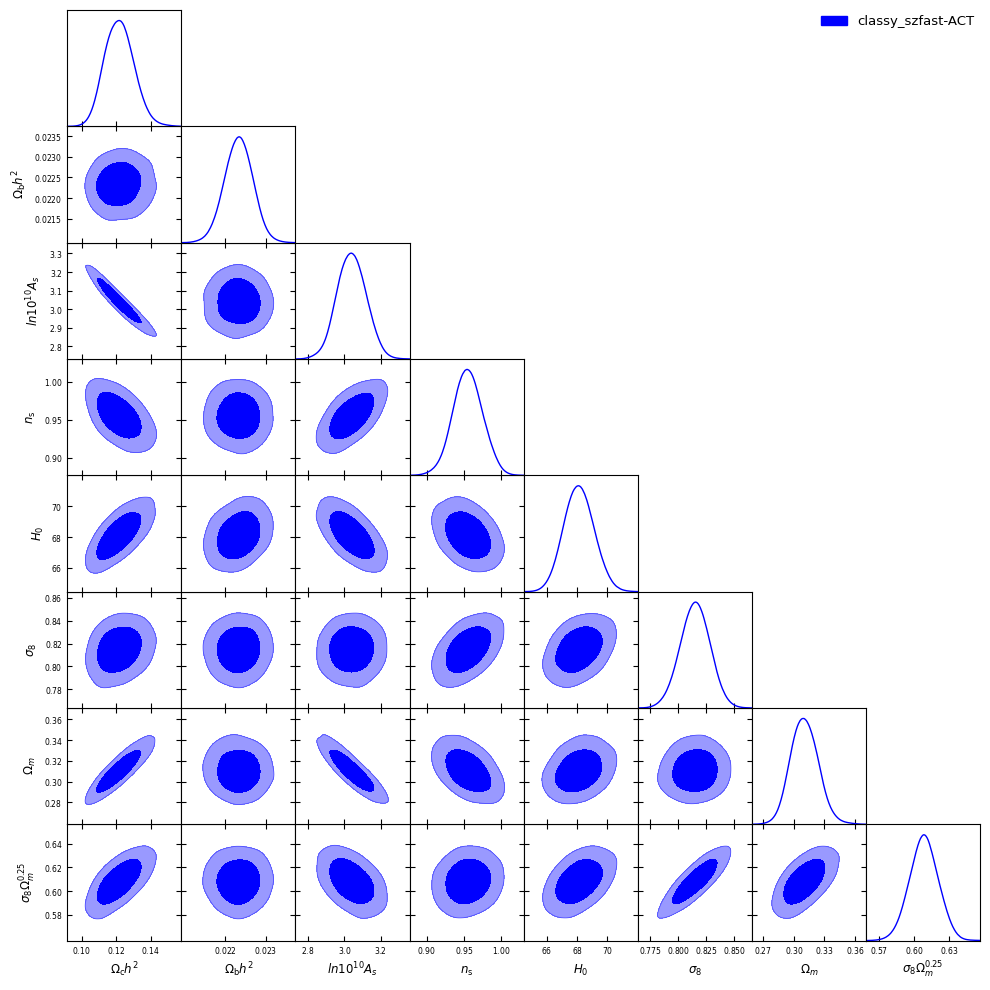

In [24]:
g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

sample_list = []
for s in range(len(all_samples)):

    sample_list.append(all_samples[s])
    
g.triangle_plot(sample_list,
    [
    'omega_cdm',
    'omega_b',
    # 'tau_reio',
    'logA',
    'n_s',
    'H0',
    'sigma8',
    'Ombc',
    'S8d25',
    ],

    filled=[True,False],
    legend_labels=[ 'classy_szfast-ACT'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}]
                   )


g.export(path_to_chains_dir +'/DR6_lensing_only_contours_classy_szfast.pdf')